In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from POTD_utility import sub_data, KNN_score, potd_pre, sir_pre, save_pre, wda_pre, wdae_pre
# WDA needs to install packages autograd ,pymanopt, tensorflow==1.0

# =============================================================================
# #Load data
# =============================================================================
mnist_train = np.loadtxt('E:/onedrive_base/OneDrive_ruc/OneDrive - ruc.edu.cn/phd_presentation/2020_11_28/code/potd_github/MNIST/' + "mnist_train.csv", delimiter=",")
mnist_test = np.loadtxt('E:/onedrive_base/OneDrive_ruc/OneDrive - ruc.edu.cn/phd_presentation/2020_11_28/code/potd_github/MNIST/' + "mnist_test.csv", delimiter=",")


In [3]:
# =============================================================================
# #a subset of data
# =============================================================================
N = 500
data_train, data_test, y_train, y_test=sub_data(mnist_train, mnist_test, pooling_ratio = 1, width = 28, height = 28, N = N)

In [4]:
# =============================================================================
# #POTD,SIR,SAVEII,WDA,WDA-EIG
# =============================================================================

#col_mean = np.sum(data_train.T*weight,1)
col_mean = data_train.mean(axis = 0)
data_train_center = data_train-col_mean
data_test_center = data_test-col_mean

kk = 50 #direction
NN=N*10
weight=np.ones((NN,)) / NN
np.random.seed(2020)

#POTD
data_potd_fit, data_potd_test = potd_pre(data_train_center, data_test_center, y_train, weight,
                                   direction= kk, with_sigma = False, use_sink=True)

#SIR
data_sir_fit, data_sir_test = sir_pre(data_train_center, data_test_center, y_train)

#SAVEII
data_save_fit, data_save_test = save_pre(data_train_center, data_test_center, y_train, kk)

#WDA
data_wda_fit, data_wda_test = wda_pre(data_train_center, data_test_center, y_train, kk, reg = 100)

#WDA-EIG
data_wdae_fit, data_wdae_test = wdae_pre(data_train_center, data_test_center, y_train, kk, reg = 100)



Compiling cost function...
Computing gradient of cost function...
 iter		   cost val	    grad. norm
    1	+1.6831713047207880e-01	1.16651203e-01
    2	+9.9635798430443817e-02	4.45233466e-02
    3	+8.0955697747864278e-02	3.89124568e-02
    4	+7.7894328699760762e-02	3.46021549e-02
    5	+6.7184592129069770e-02	2.55428202e-02
    6	+6.5359960417322338e-02	3.20660691e-02
    7	+6.0139020312592606e-02	1.43216859e-02
    8	+5.9885882566233693e-02	2.03980847e-02
    9	+5.8982327784953041e-02	1.60524648e-02
   10	+5.7722675954109043e-02	1.05065974e-02
   11	+5.7500022650610959e-02	1.58622040e-02
   12	+5.6773786139559135e-02	1.02254321e-02
   13	+5.6223887775519857e-02	8.49192155e-03
   14	+5.5794223885452514e-02	8.37593258e-03
   15	+5.5381871608932917e-02	6.57073981e-03
   16	+5.5040413704513437e-02	8.55072477e-03
   17	+5.4947756092124780e-02	1.26310876e-02
   18	+5.4630547494271126e-02	9.08978595e-03
   19	+5.4444897721652848e-02	1.07006264e-02
   20	+5.3998690914561345e-02	4.28879556e-03

In [5]:
# =============================================================================
# #Prediction Accuracy
# =============================================================================
n_neigh = 10

dim_meta = np.arange(2, kk, 1)
potd_pred = np.zeros(dim_meta.shape[0])
sir_pred = np.zeros(dim_meta.shape[0])
save_pred = np.zeros(dim_meta.shape[0])
pca_pred = np.zeros(dim_meta.shape[0])
wda_pred = np.zeros(dim_meta.shape[0])
wdae_pred = np.zeros(dim_meta.shape[0])
knn_pred = np.zeros(dim_meta.shape[0])

#KNN
score = KNN_score(data_train_center, data_test_center, y_train, y_test, nn = n_neigh)
knn_pred=knn_pred+score    

for dim_select in dim_meta:
    
    #potd
    potd_pred[dim_select-2] = KNN_score(data_potd_fit[:,range(dim_select)], data_potd_test[:,range(dim_select)], 
                      y_train, y_test, nn = n_neigh)
    
    #SIR
    if dim_select<10 :       
        sir_pred[dim_select-2] = KNN_score(data_sir_fit[:,range(dim_select)], data_sir_test[:,range(dim_select)],
                          y_train, y_test, nn = n_neigh)
    else:
        sir_pred[dim_select-2] = sir_pred[9-2]
       
    #SAVE
    save_pred[dim_select-2] = KNN_score(data_save_fit[:,range(dim_select)], data_save_test[:,range(dim_select)],
                      y_train, y_test, nn = n_neigh)
    
    #PCA
    pca = PCA(n_components = dim_select)
    pca.fit(data_train)
    pca_pred[dim_select-2] = KNN_score(pca.transform(data_train), pca.transform(data_test),
                      y_train, y_test, nn = n_neigh)
    
    #WDA
    wda_pred[dim_select-2] = KNN_score(data_wda_fit[:,range(dim_select)], data_wda_test[:,range(dim_select)],
                      y_train, y_test, nn = n_neigh)
    
    #WDA-EIG
    wdae_pred[dim_select-2] = KNN_score(data_wdae_fit[:,range(dim_select)], data_wdae_test[:,range(dim_select)],
                      y_train, y_test, nn = n_neigh)
    


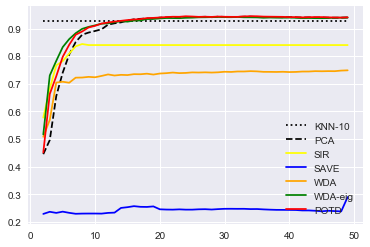

In [6]:
# =============================================================================
# # plot prediction accuracy
# =============================================================================
plt.style.use('seaborn')
%matplotlib inline
plt.plot(dim_meta, knn_pred, color='black', linestyle=':', label='KNN-10')
plt.plot(dim_meta, pca_pred, color='black', linestyle='--', label='PCA')
plt.plot(dim_meta, sir_pred, color='yellow', label='SIR')
plt.plot(dim_meta, save_pred, color='blue', label='SAVE')
plt.plot(dim_meta, wda_pred, color='orange', label='WDA')
plt.plot(dim_meta, wdae_pred, color='green', label='WDA-eig')
plt.plot(dim_meta, potd_pred, color='red', label='POTD')
plt.legend()

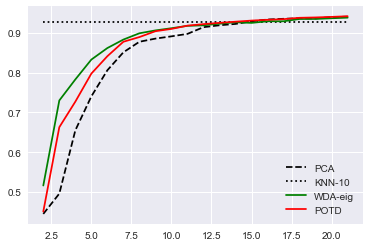

In [7]:
# =============================================================================
# # plot [2:M]
# =============================================================================
plt.style.use('seaborn')
%matplotlib inline
M=20
plt.plot(dim_meta[:M], pca_pred[:M], color='black', linestyle='--', label='PCA')
plt.plot(dim_meta[:M], knn_pred[:M], color='black', linestyle=':', label='KNN-10')
plt.plot(dim_meta[:M], wdae_pred[:M], color='green', label='WDA-eig')
plt.plot(dim_meta[:M], potd_pred[:M], color='red', label='POTD')
plt.legend()

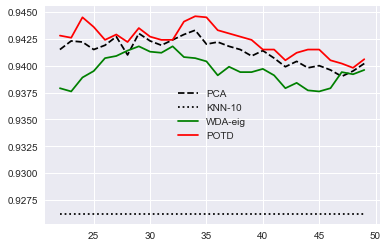

In [8]:
# =============================================================================
# # plot [M:]
# =============================================================================
plt.style.use('seaborn')
%matplotlib inline
M=20
plt.plot(dim_meta[M:], pca_pred[M:], color='black', linestyle='--', label='PCA')
plt.plot(dim_meta[M:], knn_pred[M:], color='black', linestyle=':', label='KNN-10')
plt.plot(dim_meta[M:], wdae_pred[M:], color='green', label='WDA-eig')
plt.plot(dim_meta[M:], potd_pred[M:], color='red', label='POTD')
plt.legend()

In [31]:
import time

dim_sample = np.arange(50, 301, 50)
potd_time = np.zeros(dim_sample.shape[0])
wdae_time = np.zeros(dim_sample.shape[0])

# =============================================================================
# #compare POTD, WDA-EIG time 
# =============================================================================
kk = 50 #direction
j = 0

for i in dim_sample:
    
    data_train, data_test, y_train, y_test=sub_data(mnist_train, mnist_test, pooling_ratio = 1, width = 28, height = 28, N = i)

    #col_mean = np.sum(data_train.T*weight,1)
    col_mean = data_train.mean(axis = 0)
    data_train_center = data_train-col_mean
    data_test_center = data_test-col_mean
    
    ii = i*10
    weight = np.ones((ii,)) / ii
    
    #POTD
    time_start = time.time()
    data_potd_fit, data_potd_test = potd_pre(data_train_center, data_test_center, y_train, weight,
                                   direction = kk, with_sigma = False, use_sink = True)
    time_end = time.time()
    potd_time[j] =time_end-time_start
    
    #WDA-EIG
    time_start = time.time()
    data_wdae_fit, data_wdae_test = wdae_pre(data_train_center, data_test_center, y_train, kk, reg = 100)
    time_end = time.time()
    wdae_time[j] =time_end-time_start
    
    j=j+1


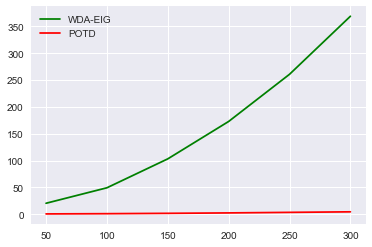

In [35]:
# =============================================================================
# # plot time(seconds)
# =============================================================================
plt.style.use('seaborn')
%matplotlib inline
plt.plot(dim_sample, wdae_time, color='green', label='WDA-EIG')
plt.plot(dim_sample, potd_time, color='red', label='POTD')
plt.legend()